## Inverse matrix using LU decomposition

In [1]:
# dependency importing
import random as rn
import numpy as np
import time as tm
from matplotlib import pyplot as plt

### Functions implementation

In [1]:
# matrix generator function
def generate_mat(dim1, dim2 = 0):
    if dim2 == 0: dim2 = dim1
    a=np.zeros((dim1,dim2),float)
    SEED = int(tm.time())
    rn.seed(SEED)
    for i in range(dim1):
        for j in range(dim2):
            a[i,j]=rn.random()
    return a, SEED

# matrix pivot function
def pivot_mat(mat, b_mat, current_row = 0):
#     base case: last row or column stops recursive calls
    if current_row in [(mat.shape[0] - 1), (mat.shape[1] - 1)]: return mat, b_mat

#     determining maximum index of current iteration
#     current row is added since we are not interested in previous
#     already pivoted rows
    max_index = mat[current_row:, current_row].argmax() + current_row

#     if current row/column of interest already is a max, we just go to next row
    if max_index == current_row:
        res = pivot_mat(mat, b_mat, current_row + 1)
        return res[0], res[1]
    
#     simple switching of rows of both A and b matrices
    switch_row = mat[max_index, :].copy()
    mat[max_index, :] = mat[current_row, :]
    mat[current_row, :] = switch_row    
    switch_row = b_mat[max_index, :].copy()
    b_mat[max_index, :] = b_mat[current_row, :]
    b_mat[current_row, :] = switch_row    
    
#     recursive call for next rows/columns
    res = pivot_mat(mat, b_mat, current_row + 1)
    return res[0], res[1]

# LU decomposer function
def decompose_LU(mat, current_row = 0):
#     L matrix is determined column by column
#     U matrix is determined row by row
    L_vect = np.zeros((mat.shape[0], 1))
    U_vect = np.zeros((1, mat.shape[1]))

#     filling L vector with zeros from top
    for i in range(current_row):
        L_vect[i, 0] = 0
#     filling L vector with 1 diagonally
    L_vect[current_row, 0] = 1
    
#     finding elimination coefficients to fill L vector
    for i in range(current_row + 1, mat.shape[0]):
        L_vect[i, 0] = mat[i, current_row] / mat[current_row, current_row]
        
#     filling gaussian coefficients to U vector
    for i in range(current_row, mat.shape[1]):
        U_vect[0, i] = mat[current_row, i]
        
#     if current row index is out of shape, return the last row/column of L U vectors
    if current_row + 1 == mat.shape[0]: return L_vect, U_vect
    
#     gaussian elimination
    for i in range(current_row + 1, mat.shape[0]):
        for j in range(current_row + 1, mat.shape[1]):
            mat[i, j] = mat[i, j] - mat[current_row, j] * (mat[i, current_row] / mat[current_row, current_row])
        for j in range(current_row + 1):
            mat[i, j] = 0
            
#     recursive call returning tuple of next rows and cols of L and U vectors
    res = decompose_LU(mat, current_row + 1)
    
#     simple stacking current and next results
    return np.hstack((L_vect, res[0])), np.vstack((U_vect, res[1]))

# matrix inverser function
def inverse_mat(L, U, pivoted_b, current_row = 0):
#     slicing b vector from b matrix
    b = pivoted_b[:, current_row].reshape((pivoted_b.shape[0], 1))
    
#     if last row is reached, returning last culumn of inverse matrix
    if current_row == L.shape[1] - 1: return np.linalg.solve(U, np.linalg.solve(L, b))
    
#     else returning horizontally stacked vector of current column and next columns
    return np.hstack((np.linalg.solve(U, np.linalg.solve(L, b)), inverse_mat(L, U, pivoted_b, current_row + 1)))

# root mean square or norm of matrix
def rms_norm(error_mat):
    error_mat = error_mat.flatten()
    squared_sum = 0
    for i in range(error_mat.shape[0]):
        squared_sum += error_mat[i]**2
    return np.sqrt(squared_sum)

### Generation of 20 by 20 matrix of random numbers in [0, 1] range

In [46]:
# generation of matrix of nxn dimension
n = 20
mat, seed = generate_mat(n)
print('Seed of generated matrix is ' + str(seed))

Seed of generated matrix is 1519022768


### Applying implemented function to find inverse of the matrix

In [47]:
# initial b matrix for inverse matrix calculation
b_mat = np.identity(mat.shape[0])

# b_mat identity matrix also have to be pivoted since it is RHS of linear equations
pivoted_mat, pivoted_b = pivot_mat(mat.copy(), b_mat.copy())

# LU decomposition using gaussian elimination steps
l, u = decompose_LU(pivoted_mat.copy())

# solving linear equations for pivoted b matrix and LU matrices
inv_mat = inverse_mat(l, u, pivoted_b)

### Accuracy test using RMS error

In [48]:
# checking for root-mean-square error of matrix inverse 
accuracy_identity = np.matmul(mat, inv_mat)
error = b_mat - accuracy_identity
error = rms_norm(error.copy())
print('Root-mean-square error of inverse matrix is ' + str(error))

Root-mean-square error of inverse matrix is 1.12373117757e-13


### Estimation of condition number

In [49]:
# condition number estimation
cond_num = rms_norm(mat) * rms_norm(inv_mat)
print('Condition number of A according to inverse of A is ' + str(cond_num))

Condition number of A according to inverse of A is 202.209934442


Well-condition concept is relativistic. There is no absolute threshold for being ill or well conditioned matrix system. At each iteration different condition numbers are generated and at last iteration condition number of 202 was obtained. Relatively to other iterations it is more well conditioned than previosly obtained matrices in general.

### Condition number vs Error relation test

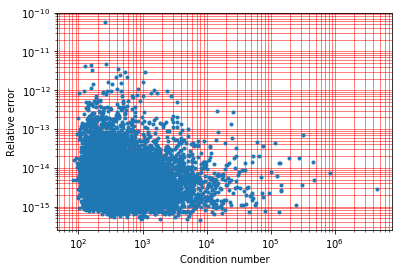

In [45]:
from matplotlib import pyplot as plt

# generation of A matrix 10000 times
# calculation of relative error of inverse estimation
# and condition number to see correlation of them
def custom_proc(dim, num_points):
    err_list = []
    cond_list = []
    for i in range(num_points):
        mat = np.random.rand(dim, dim)
        b_mat = np.identity(mat.shape[0])
        pivoted_mat, pivoted_b = pivot_mat(mat.copy(), b_mat.copy())
        l, u = decompose_LU(pivoted_mat.copy())
        inv_mat = inverse_mat(l, u, pivoted_b)
        accuracy_identity = np.matmul(mat, inv_mat)
        error = b_mat - accuracy_identity
        error = rms_norm(error.copy()) / rms_norm(inv_mat)
        cond_num = rms_norm(mat) * rms_norm(inv_mat)
        err_list += [error]
        cond_list += [cond_num]
    return err_list, cond_list

err_list, cond_list = custom_proc(20, 10000)
plt.loglog(cond_list, err_list, '.')
plt.xlabel('Condition number')
plt.ylabel('Relative error')
plt.grid(color='r', linestyle='-', linewidth=0.5, which='both')
plt.show()

From above logarithmic scatter plot it is clearly seen that there is no any pattern in relative error vs condition number. That means relative error and condition number are not highly correlated to each other and there is no any inter consistency.

### Execution time test

In [57]:
np_time = []
np_acc = []
custom_time = []
custom_acc = []
for _ in range(100):
    np_start = tm.time()
    np_inv = np.linalg.inv(mat)
    np_spent = tm.time() - np_start
    custom_start = tm.time()
    pivoted_mat, pivoted_b = pivot_mat(mat.copy(), b_mat.copy())
    l, u = decompose_LU(pivoted_mat.copy())
    custom_inv = inverse_mat(l, u, pivoted_b)
    custom_spent = tm.time() - custom_start
    np_identity = np.matmul(mat, np_inv)
    np_error = b_mat - np_identity
    np_error = rms_norm(np_error.copy())
    custom_identity = np.matmul(mat, custom_inv)
    custom_error = b_mat - custom_identity
    custom_error = rms_norm(custom_error.copy())
    np_time += [np_spent]
    np_acc += [np_error]
    custom_time += [custom_spent]
    custom_acc += [custom_error]
    
print('Average time for numpy inverse function execution is: ' + str(sum(np_time)/float(len(np_time))) + ' secs.')
print('Average time for LU decomposition inverse function execution is: ' + str(sum(custom_time)/float(len(custom_time))) + ' secs.')
print('Average RMS error for numpy inverse function execution is: ' + str(sum(np_acc)/float(len(np_acc))))
print('Average RMS error for LU decomposition inverse function execution is: ' + str(sum(custom_acc)/float(len(custom_acc))))

Average time for numpy inverse function execution is: 8.000612258911133e-05 secs.
Average time for LU decomposition inverse function execution is: 0.007870438098907471 secs.
Average RMS error for numpy inverse function execution is: 1.00188023699e-14
Average RMS error for LU decomposition inverse function execution is: 1.12373117757e-13


Numpy inverse function is better than my implementation in terms of both time and accuracy. From web sources it is seen that numpy inverse is calculated also using gaussian elimination and LU factorization methodology, so comparison is consistent. It is clear that numpy is a wrapped C/C++ package and highly optimized in terms of various complexities, so numpy will be anyway faster than any Python implementation.